<a href="https://colab.research.google.com/github/Diego251Fagundes/Data-Science-Machine-Learning-Studies/blob/main/atividade_pr%C3%A1tica%E2%80%93engenharia_de_atributos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🎯 Objetivo
Aplicar conceitos de feature engineering e avaliar como novas variáveis podem melhorar o desempenho de um modelo de Random Forest na predição de sobrevivência de passageiros do Titanic.

In [ ]:
# === Imports básicos ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.inspection import permutation_importance

# Estética simples para plots (sem estilos específicos)
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.grid"] = True

# 1) Carregando e explorando os dados

In [ ]:
# Carregar dataset
df = pd.read_csv('train.csv')

print("Shape:", df.shape)
display(df.head())

Shape: (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
# Estatísticas descritivas rápidas
df.describe().T

,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


### Definição de variáveis

- **X_base**: conjunto de features **originais** (todas as colunas exceto `class`).  
- **y**: vetor de rótulos (0, 1, 2).


In [ ]:
# Separar X e y (baseline com features originais)
feature_cols = [c for c in df.columns if c != "Survived"]
X_base = df[feature_cols].copy()
y = df["Survived"].values

print("N features (originais):", X_base.shape[1])

N features (originais): 11


## 2) Baseline: Random Forest com features originais

Usaremos validação cruzada estratificada (5 folds) e métrica **acurácia** como referência didática.


In [ ]:
# Configuração de CV e modelo
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

# Selecionar apenas as features especificadas para o Modelo A (baseline)
feature_cols_baseline_A = ["Pclass", "Sex", "Age", "Fare"]
X_baseline_A = df[feature_cols_baseline_A].copy()

# Pré-processamento para o Modelo A:
# 1. Codificar a coluna 'Sex' (male/female) para numérica
X_baseline_A['Sex'] = X_baseline_A['Sex'].map({'male': 0, 'female': 1})

# 2. Lidar com valores ausentes nas colunas numéricas - Imputar com a média
# Aplicar apenas nas colunas 'Age' e 'Fare'
X_baseline_A['Age'] = X_baseline_A['Age'].fillna(X_baseline_A['Age'].mean())
X_baseline_A['Fare'] = X_baseline_A['Fare'].fillna(X_baseline_A['Fare'].mean())


# Validar o Modelo A
scores_baseline_A = cross_val_score(rf, X_baseline_A, y, cv=cv, scoring="accuracy", n_jobs=-1)
print(f"Acurácia (CV=5) - Modelo A (Baseline): {scores_baseline_A.mean():.4f} ± {scores_baseline_A.std():.4f}")

Acurácia (CV=5) - Modelo A (Baseline): 0.8327 ± 0.0259


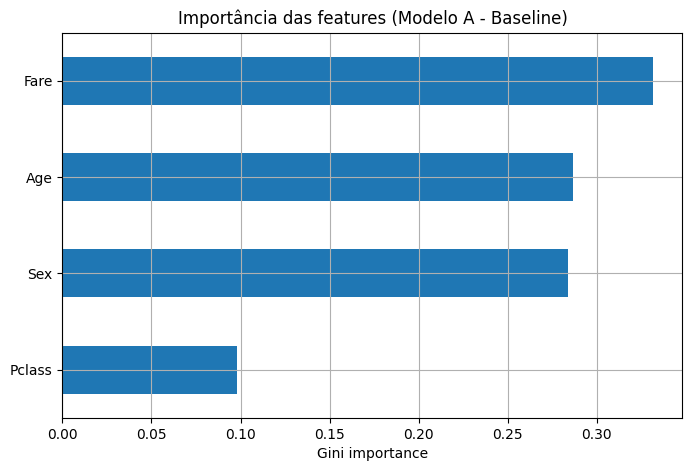

In [ ]:
# Ajustar o modelo baseline (Modelo A) em todos os dados para visualizar importâncias
# Usar X_baseline_A que contém as features Pclass, Sex, Age, Fare pré-processadas
rf.fit(X_baseline_A, y)
importances_base = pd.Series(rf.feature_importances_, index=X_baseline_A.columns).sort_values(ascending=False)

ax = importances_base.head(15).sort_values().plot.barh()
ax.set_title("Importância das features (Modelo A - Baseline)")
ax.set_xlabel("Gini importance")
plt.show()

## 3) Feature Engineering

Criando 2 novas features `FamilySize` e `IsAlone`.

In [ ]:
# Criar uma cópia de trabalho para engenharia de atributos
df_engineered = df.copy()

# Feature 1: FamilySize
df_engineered['FamilySize'] = df_engineered['SibSp'] + df_engineered['Parch'] + 1

# Feature 2: IsAlone
df_engineered['IsAlone'] = (df_engineered['FamilySize'] == 1).astype(int)

print("DataFrame com as 2 novas features:")
display(df_engineered[['SibSp', 'Parch', 'FamilySize', 'IsAlone']].head())

DataFrame com novas features:


,SibSp,Parch,FamilySize,IsAlone
0,1,0,2,0
1,1,0,2,0
2,0,0,1,1
3,1,0,2,0
4,0,0,1,1


## 4) Comparando o desempenho: Modelo A vs. Modelo B

Vamos criar o conjunto de features para o Modelo B, que inclui as features do Modelo A (`Pclass`, `Sex`, `Age`, `Fare`) mais as novas features `FamilySize` e `IsAlone`. Em seguida, avaliaremos o desempenho.

In [ ]:
# Criar o conjunto de features para o Modelo B: Modelo A + FamilySize e IsAlone
feature_cols_modelo_B = ["Pclass", "Sex", "Age", "Fare", "FamilySize", "IsAlone"]
# Usar o dataframe df_engineered
X_modelo_B = df_engineered[feature_cols_modelo_B].copy()

# Pré-processamento para o Modelo B (aplicar o mesmo que no Modelo A):
X_modelo_B['Sex'] = X_modelo_B['Sex'].map({'male': 0, 'female': 1})
X_modelo_B['Age'] = X_modelo_B['Age'].fillna(df['Age'].mean())
X_modelo_B['Fare'] = X_modelo_B['Fare'].fillna(df['Fare'].mean())

# Validar o Modelo B
scores_modelo_B = cross_val_score(rf, X_modelo_B, y, cv=cv, scoring="accuracy", n_jobs=-1)

print(f"Acurácia (CV=5) - Modelo B (Com FamilySize e IsAlone): {scores_modelo_B.mean():.4f} ± {scores_modelo_B.std():.4f}")
print(f"\nAcurácia (CV=5) - Modelo A (Baseline): {scores_baseline_A.mean():.4f} ± {scores_baseline_A.std():.4f}")

Acurácia (CV=5) - Modelo B (Com FamilySize e IsAlone): 0.8193 ± 0.0177

Acurácia (CV=5) - Modelo A (Baseline): 0.8327 ± 0.0259


## 5) Criando 3 features.

### Feature 1: Deck da Cabine (`CabinDeck`)

**Justificativa Lógica:** O deck da cabine pode estar relacionado à localização no navio, o que pode ter influenciado as chances de sobrevivência durante o naufrágio. Cabines em decks superiores podem ter tido acesso mais fácil aos botes salva-vidas. Extrair a primeira letra da cabine (que representa o deck) pode capturar essa relação.

In [ ]:
# Criar uma cópia de trabalho para adicionar as novas features (baseado em df_engineered)
df_engineered_v2 = df_engineered.copy()

# Feature 1: Deck da Cabine (CabinDeck)

# Extrair a primeira letra da cabine (representa o deck)
df_engineered_v2['CabinDeck'] = df_engineered_v2['Cabin'].str[0]

# Preencher valores ausentes com 'Unknown'
df_engineered_v2['CabinDeck'] = df_engineered_v2['CabinDeck'].fillna('Unknown')

print("Distribuição dos Decks:")
display(df_engineered_v2['CabinDeck'].value_counts())

Distribuição dos Decks:


,count
CabinDeck,
Unknown,687
C,59
B,47
D,33
E,32
A,15
F,13
G,4
T,1


### Feature 2: Grupo de Idade (`AgeGroup`)

**Justificativa Lógica:** A idade é um fator importante para a sobrevivência. Crianças (`Master`) e idosos podem ter sido priorizados ou, inversamente, ter mais dificuldade. Agrupar as idades em categorias (ex: Criança, Adolescente, Adulto, Idoso) pode ajudar o modelo a capturar padrões relacionados a diferentes fases da vida, mesmo com valores ausentes na coluna `Age`.

In [ ]:
# Preencher valores ausentes de 'Age' com a média ANTES de criar os grupos de idade
df_engineered_v2['Age'].fillna(df_engineered_v2['Age'].mean(), inplace=True)

# Criar grupos de idade
bins = [0, 12, 18, 60, np.inf] # Criança, Adolescente, Adulto, Idoso
labels = ['Child', 'Teenager', 'Adult', 'Senior']
df_engineered_v2['AgeGroup'] = pd.cut(df_engineered_v2['Age'], bins=bins, labels=labels, right=False)

print("\nDistribuição dos Grupos de Idade:")
display(df_engineered_v2['AgeGroup'].value_counts())


Distribuição dos Grupos de Idade:


/tmp/ipython-input-3667009298.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_engineered_v2['Age'].fillna(df_engineered_v2['Age'].mean(), inplace=True)


,count
AgeGroup,
Adult,752
Child,68
Teenager,45
Senior,26


### Feature 3: Tarifa por Pessoa (`FarePerPerson`)

**Justificativa Lógica:** A tarifa total (`Fare`) é uma característica, mas a tarifa por pessoa pode ser mais informativa, especialmente para grupos familiares. Uma tarifa alta por pessoa pode indicar uma cabine de classe superior ou um tratamento diferenciado, ambos potencialmente correlacionados com a sobrevivência. Dividir a tarifa pelo tamanho da família (`FamilySize`) normaliza essa feature.

In [ ]:
# Lidar com FamilySize = 0 para evitar divisão por zero. Assumimos FamilySize >= 1.
# FamilySize já foi criada em df_engineered e copiada para df_engineered_v2
# Garante que não há zeros em FamilySize
df_engineered_v2['FamilySize'] = df_engineered_v2['FamilySize'].replace(0, 1)

# Criar FarePerPerson
df_engineered_v2['FarePerPerson'] = df_engineered_v2['Fare'] / df_engineered_v2['FamilySize']

print("\nPrimeiras linhas com a nova feature FarePerPerson:")
display(df_engineered_v2[['Fare', 'FamilySize', 'FarePerPerson']].head())


Primeiras linhas com a nova feature FarePerPerson:


,Fare,FamilySize,FarePerPerson
0,7.2500,2,3.62500
1,71.2833,2,35.64165
2,7.9250,1,7.92500
3,53.1000,2,26.55000
4,8.0500,1,8.05000


In [ ]:
print("\nDataFrame com todas as novas features:")
display(df_engineered_v2[['Name', 'Cabin', 'CabinDeck', 'Age', 'AgeGroup', 'Fare', 'FamilySize', 'FarePerPerson']].head())


DataFrame com todas as novas features:


,Name,Cabin,CabinDeck,Age,AgeGroup,Fare,FamilySize,FarePerPerson
0,"Braund, Mr. Owen Harris",NaN,Unknown,22.0,Adult,7.2500,2,3.62500
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",C85,C,38.0,Adult,71.2833,2,35.64165
2,"Heikkinen, Miss. Laina",NaN,Unknown,26.0,Adult,7.9250,1,7.92500
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",C123,C,35.0,Adult,53.1000,2,26.55000
4,"Allen, Mr. William Henry",NaN,Unknown,35.0,Adult,8.0500,1,8.05000


## 6) Treinando o modelo novamente com as 5 novas features

In [ ]:
# Features para o Modelo C: Modelo B + CabinDeck, AgeGroup, FarePerPerson
feature_cols_modelo_C = ["Pclass", "Sex", "Age", "Fare", "FamilySize", "IsAlone", "CabinDeck", "AgeGroup", "FarePerPerson"]
X_modelo_C = df_engineered_v2[feature_cols_modelo_C].copy()

# Pré-processamento para o Modelo C:
X_modelo_C['Sex'] = X_modelo_C['Sex'].map({'male': 0, 'female': 1})
X_modelo_C['Fare'] = X_modelo_C['Fare'].fillna(df_engineered_v2['Fare'].mean())
X_modelo_C = pd.get_dummies(X_modelo_C, columns=['CabinDeck', 'AgeGroup'], drop_first=False)

print("Shape do X_modelo_C após One-Hot Encoding:", X_modelo_C.shape)
display(X_modelo_C.head())

Shape do X_modelo_C após One-Hot Encoding: (891, 20)


,Pclass,Sex,Age,Fare,FamilySize,IsAlone,FarePerPerson,CabinDeck_A,CabinDeck_B,CabinDeck_C,CabinDeck_D,CabinDeck_E,CabinDeck_F,CabinDeck_G,CabinDeck_T,CabinDeck_Unknown,AgeGroup_Child,AgeGroup_Teenager,AgeGroup_Adult,AgeGroup_Senior
0,3,0,22.0,7.2500,2,0,3.62500,False,False,False,False,False,False,False,False,True,False,False,True,False
1,1,1,38.0,71.2833,2,0,35.64165,False,False,True,False,False,False,False,False,False,False,False,True,False
2,3,1,26.0,7.9250,1,1,7.92500,False,False,False,False,False,False,False,False,True,False,False,True,False
3,1,1,35.0,53.1000,2,0,26.55000,False,False,True,False,False,False,False,False,False,False,False,True,False
4,3,0,35.0,8.0500,1,1,8.05000,False,False,False,False,False,False,False,False,True,False,False,True,False


# Avaliando o desempenho do Modelo C

In [ ]:
# Validar o Modelo C
scores_modelo_C = cross_val_score(rf, X_modelo_C, y, cv=cv, scoring="accuracy", n_jobs=-1)

print(f"Acurácia (CV=5) - Modelo C (Novas Features): {scores_modelo_C.mean():.4f} ± {scores_modelo_C.std():.4f}")
print(f"\nAcurácia (CV=5) - Modelo B (Com FamilySize e IsAlone): {scores_modelo_B.mean():.4f} ± {scores_modelo_B.std():.4f}")
print(f"Acurácia (CV=5) - Modelo A (Baseline): {scores_baseline_A.mean():.4f} ± {scores_baseline_A.std():.4f}")

Acurácia (CV=5) - Modelo C (Novas Features): 0.8125 ± 0.0172

Acurácia (CV=5) - Modelo B (Com FamilySize e IsAlone): 0.8193 ± 0.0177
Acurácia (CV=5) - Modelo A (Baseline): 0.8327 ± 0.0259


# Importância das Features no Modelo C

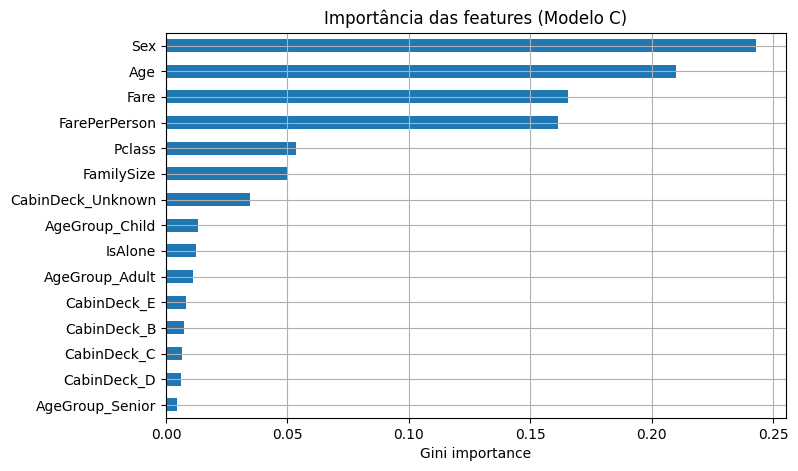

In [ ]:
rf.fit(X_modelo_C, y)
importances_C = pd.Series(rf.feature_importances_, index=X_modelo_C.columns).sort_values(ascending=False)

ax = importances_C.head(15).sort_values().plot.barh()
ax.set_title("Importância das features (Modelo C)")
ax.set_xlabel("Gini importance")
plt.show()

Em resumo, a análise de importância sugere que Sex, Age, Fare e a nova feature FarePerPerson foram as que mais ajudaram o modelo a fazer as previsões de sobrevivência no Modelo C. As outras novas features (FamilySize, IsAlone, CabinDeck, AgeGroup) tiveram um impacto menor nesta configuração do modelo Random Forest.

Isso não significa que as features com menor importância não sejam úteis, mas que neste modelo específico e com esta métrica de importância, elas contribuíram menos individualmente do que as principais.

# 🧠 Perguntas para responder

# 1. Qual foi a acurácia média antes e depois das novas features?

**R:** A acurácia média antes de adicionar as 5 novas features (Modelo A - Baseline) foi de 0.8327 ± 0.0259.

Após adicionar as 5 novas features (Modelo C), a acurácia média foi de 0.8125 ± 0.0172.

# 2. Quais variáveis foram mais importantes segundo o modelo?

**R:** Segundo o modelo Random Forest (Modelo C), as variáveis mais importantes (com base na Gini Importance) para a predição de sobrevivência foram:

Sex, Age, Fare, FarePerPerson

# 3. Alguma feature criada teve efeito negativo no desempenho?

**R:** Observamos que tanto o Modelo B quanto o Modelo C tiveram uma acurácia média ligeiramente menor do que o Modelo A (Baseline). Isso sugere que, nesta configuração específica do modelo Random Forest e com estas features criadas, a adição delas não trouxe uma melhoria no desempenho (acurácia), e em termos de acurácia média, o desempenho foi nominalmente menor.

Não podemos dizer definitivamente que uma feature individual teve um efeito negativo, pois o desempenho é resultado da interação de todas as features no modelo. No entanto, o conjunto das novas features no Modelo C não melhorou a acurácia em relação ao baseline.

# 4. Que paralelos podem ser feitos com sua área (ex.: variáveis derivadas em dados biológicos, clínicos ou experimentais)?